I analyze a dataset containing simulated gravitational-wave signals from merging black holes. In particular, each source has the following features:
- mtot: the total mass of the binary
- q: the mass ratio
- chi1x, chi1y, chi1z, chi2x, chi2y, chi2z: the components of the black-hole spins in a suitable reference frame.
- ra, dec: the location of the source in the sky
- iota: the inclination of the orbital plane'
- psi: the polarization angle (gravitational waves have two polarization states much like light)
- z: the redshift
The detectability is defined using the 'snr' (signal-to-noise ratio): LIGO will (not) see a source if snr>12 (snr<12). The resulting 0-1 labels are reported in the 'det' attribute in the dataset.

The aim is to separate sources that are detectables from those that aren't. I classify the data with the following methods:
- Decision Tree Classifier (using Entropy and Gini splitting criteria)
- Bagging
- Random Forset
- Boosting

In [17]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st
import sklearn.manifold
import sklearn.model_selection

# Preparation of the dataset

In [18]:
import h5py
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
list(f.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [19]:
import pandas as pd
d = {i: f[i][:] for i in f.keys()}
dataset_tot = pd.DataFrame(data=d, dtype=np.float16)
dataset_tot

c:\Users\marti\Anaconda\Lib\site-packages\pandas\core\construction.py:820: RuntimeWarning: overflow encountered in cast
  subarr = np.asarray(arr, dtype=dtype)


,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,det,iota,mtot,psi,q,ra,snr,z
0,-0.307129,0.276123,-0.430664,-0.161133,-0.092346,-0.414551,-0.329590,0.0,1.809570,907.00000,1.286133,0.625000,-3.117188,0.822266,2.140625
1,-0.734863,-0.498535,-0.298096,0.057526,-0.845215,0.014709,0.526855,0.0,0.820801,59.09375,0.934082,0.986816,1.360352,1.092773,2.439453
2,-0.057831,-0.703613,-0.354492,-0.215576,0.016327,0.130493,0.315918,0.0,2.007812,44.59375,1.535156,0.286133,0.079956,1.305664,1.869141
3,0.015259,-0.202515,-0.492676,-0.237061,-0.365479,-0.875977,0.432129,0.0,2.017578,534.50000,3.064453,0.539062,-1.780273,9.109375,0.427979
4,-0.016724,0.007851,0.005009,0.147461,0.231934,0.086731,-0.458740,1.0,2.037109,574.00000,0.752441,0.846191,2.789062,17.531250,0.772461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999995,-0.192017,-0.132080,0.099854,0.244263,-0.610352,0.205688,0.227539,0.0,1.711914,47.18750,0.458984,0.721680,2.748047,0.550781,2.943359
19999996,-0.004265,-0.056183,-0.030457,0.080688,-0.263672,-0.028503,-0.289551,0.0,1.796875,319.50000,2.011719,0.276367,-3.009766,6.304688,1.348633
19999997,-0.558105,-0.107605,0.065247,0.305664,-0.212524,-0.412109,-0.236938,0.0,0.894531,536.50000,1.776367,0.910156,-1.638672,9.976562,0.826660
19999998,0.084778,-0.042755,0.017715,0.145630,0.474365,0.744629,0.104065,0.0,1.102539,879.00000,1.317383,0.287598,2.212891,0.920410,3.125000


In [20]:
# I consider a subset of the dataset
dataset = dataset_tot[:100000]

In [21]:
# train-test split
data_train, data_test = sklearn.model_selection.train_test_split(dataset, test_size=0.25, train_size=0.75)

In [22]:
X_train = data_train.drop(['det', 'snr'], axis=1)  # I don't train the data on snr and det, it's the solution!
X_test = data_test.drop(['det', 'snr'], axis=1)
Y_train = data_train['det']
Y_test = data_test['det']

In [23]:
# Arrays in which I will save the results
algorithm = ['DecisionTree Entropy', 'DecisionTree Gini', 'Bagging', 'Random Forest', 'Boosting']
complet = []
contamin = []
accur = []   # number of correctly classified samples

# Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from astroML.utils import completeness_contamination

Cross-validation

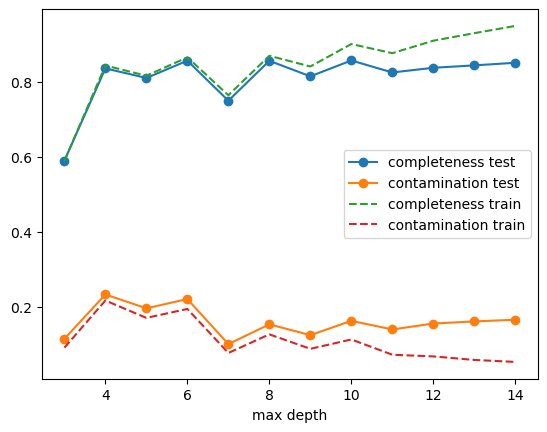

The best maximum depth is 8.00


In [25]:
# At first I perform cross-validation to select the best max_depth
completeness_train = []
contamination_train = []
completeness_test = []
contamination_test = []
kvals = np.arange(3, 15)

for k in kvals:
    dtree = DecisionTreeClassifier(max_depth=k, criterion='entropy')
    dtree.fit(X_train, Y_train)

    y_pred = dtree.predict(X_test)
    completeness, contamination = completeness_contamination(y_pred, Y_test)
    completeness_test.append(completeness)
    contamination_test.append(contamination)

    y_pred = dtree.predict(X_train)
    completeness, contamination = completeness_contamination(y_pred, Y_train)
    completeness_train.append(completeness)
    contamination_train.append(contamination)

# Plot
plt.plot(kvals,completeness_test, '-o', label='completeness test')
plt.plot(kvals,contamination_test, '-o', label='contamination test')
plt.plot(kvals,completeness_train, '--', label='completeness train')
plt.plot(kvals,contamination_train, '--', label='contamination train')
plt.xlabel('max depth')
plt.legend()
plt.show()

# I select the best max depth taking into account the risk of overfitting
completeness_train = np.array(completeness_train)
completeness_test = np.array(completeness_test)
mask = (completeness_train - completeness_test < 0.02)&(completeness_test>0.8)
best_depth = kvals[mask][-1]
print("The best maximum depth is %.2f" %best_depth)

Decision Tree Classifier, splitting criteria Entropy and Gini

In [26]:
dtree_entropy = DecisionTreeClassifier(max_depth=best_depth, criterion='entropy')
dtree_entropy.fit(X_train, Y_train)
y_pred = dtree_entropy.predict(X_test)

completeness, contamination = completeness_contamination(y_pred, Y_test)
accuracy = accuracy_score(Y_test, y_pred)
print('DecisionTreeClassifier - Entropy')
print("completeness = ", completeness)
print("contamination = ", contamination)
print("accuracy = ", accuracy)
complet.append(completeness)
contamin.append(contamination)
accur.append(accuracy)

# confusion matrix
c_matrix = confusion_matrix(Y_test, y_pred)
print('Confusion matrix:')
print(c_matrix)

print('-----------------------------------')

dtree_gini = DecisionTreeClassifier(max_depth=best_depth, criterion='gini')
dtree_gini.fit(X_train, Y_train)
y_pred = dtree_gini.predict(X_test)

completeness, contamination = completeness_contamination(y_pred, Y_test)
accuracy = accuracy_score(Y_test, y_pred)
print('DecisionTreeClassifier - Gini')
print("completeness = ", completeness)
print("contamination = ", contamination)
print("accuracy = ", accuracy)
complet.append(completeness)
contamin.append(contamination)
accur.append(accuracy)

# confusion matrix
c_matrix = confusion_matrix(Y_test, y_pred)
print('Confusion matrix:')
print(c_matrix)

DecisionTreeClassifier - Entropy
completeness =  0.8571826280623608
contamination =  0.15295735900962862
accuracy =  0.95724
Confusion matrix:
[[20852   556]
 [  513  3079]]
-----------------------------------
DecisionTreeClassifier - Gini
completeness =  0.8271158129175946
contamination =  0.1264334019406057
accuracy =  0.95796
Confusion matrix:
[[20978   430]
 [  621  2971]]


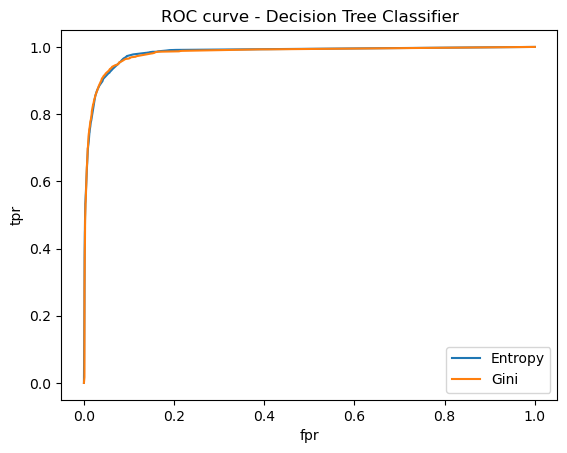

In [27]:
# ROC curve
y_prob = dtree_entropy.predict_proba(X_test)[:,1]
fpr, tpr, thresholds =roc_curve(Y_test, y_prob)

plt.plot(fpr, tpr, label='Entropy')

y_prob = dtree_gini.predict_proba(X_test)[:,1]
fpr, tpr, thresholds =roc_curve(Y_test, y_prob)

plt.plot(fpr, tpr, label='Gini')

plt.title('ROC curve - Decision Tree Classifier')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(loc='lower right')
plt.show()

# Bagging

In [28]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(dtree_entropy, n_estimators=500, max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
bag_clf.fit(X_train, Y_train)
y_pred = bag_clf.predict(X_test)

completeness, contamination = completeness_contamination(y_pred, Y_test)
accuracy = accuracy_score(Y_test, y_pred)
print('Bagging')
print("completeness = ", completeness)
print("contamination = ", contamination)
print("accuracy = ", accuracy)
complet.append(completeness)
contamin.append(contamination)
accur.append(accuracy)

# confusion matrix
c_matrix = confusion_matrix(Y_test, y_pred)
print('Confusion matrix:')
print(c_matrix)

Bagging
completeness =  0.7964922048997772
contamination =  0.19702497895032275
accuracy =  0.94268
Confusion matrix:
[[20706   702]
 [  731  2861]]


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

ranfor = RandomForestClassifier(10)
ranfor.fit(X_train, Y_train)
y_pred = ranfor.predict(X_test)

completeness, contamination = completeness_contamination(y_pred, Y_test)
accuracy = accuracy_score(Y_test, y_pred)
print('RandomForest')
print("completeness = ", completeness)
print("contamination = ", contamination)
print("accuracy = ", accuracy)
complet.append(completeness)
contamin.append(contamination)
accur.append(accuracy)

# confusion matrix
c_matrix = confusion_matrix(Y_test, y_pred)
print('Confusion matrix:')
print(c_matrix)

RandomForest
completeness =  0.8265590200445434
contamination =  0.09701946472019465
accuracy =  0.96232
Confusion matrix:
[[21089   319]
 [  623  2969]]


# Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gradboost = GradientBoostingClassifier()
gradboost.fit(X_train, Y_train)
y_pred = gradboost.predict(X_test)

completeness, contamination = completeness_contamination(y_pred, Y_test)
accuracy = accuracy_score(Y_test, y_pred)
print('RandomForest')
print("completeness = ", completeness)
print("contamination = ", contamination)
print("accuracy = ", accuracy)
complet.append(completeness)
contamin.append(contamination)
accur.append(accuracy)

# confusion matrix
c_matrix = confusion_matrix(Y_test, y_pred)
print('Confusion matrix:')
print(c_matrix)

RandomForest
completeness =  0.8608017817371938
contamination =  0.10739030023094688
accuracy =  0.96512
Confusion matrix:
[[21036   372]
 [  500  3092]]


Roc-curves

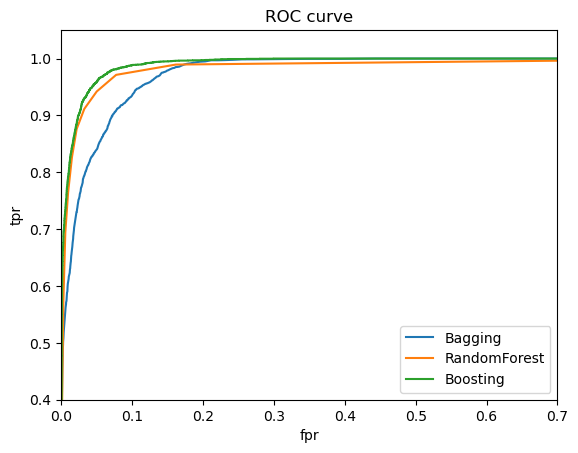

In [31]:
# ROC curve
y_prob = bag_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds =roc_curve(Y_test, y_prob)
plt.plot(fpr, tpr, label='Bagging')

y_prob = ranfor.predict_proba(X_test)[:,1]
fpr, tpr, thresholds =roc_curve(Y_test, y_prob)
plt.plot(fpr, tpr, label='RandomForest')

y_prob = gradboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds =roc_curve(Y_test, y_prob)
plt.plot(fpr, tpr, label='Boosting')

plt.title('ROC curve')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(loc='lower right')
plt.xlim(0.0, 0.7)
plt.ylim(0.4, 1.05)
plt.show()

# Results

In [32]:
final_table = pd.DataFrame({
    'Algorithm': algorithm,
    'Completeness': complet,
    'Contamination': contamin,
    'Accuracy': accur})

final_table

,Algorithm,Completeness,Contamination,Accuracy
0,DecisionTree Entropy,0.8571826280623608,0.15295735900962862,0.95724
1,DecisionTree Gini,0.8271158129175946,0.1264334019406057,0.95796
2,Bagging,0.7964922048997772,0.19702497895032275,0.94268
3,Random Forest,0.8265590200445434,0.09701946472019465,0.96232
4,Boosting,0.8608017817371938,0.10739030023094688,0.96512
